In [1]:
import numpy as np
import math
import csv
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from skbio.stats.composition import clr
from scipy.spatial.distance import dice
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

sns.set_style("ticks")
sns.palplot(sns.color_palette("colorblind", 10))

%matplotlib inline

In [2]:
COLORS = sns.color_palette("colorblind", 10)
TAXONOMIC_PROFILER = 'burst'
CLR = True
# CLASSIFIER = lambda: OneVsRestClassifier(RandomForestClassifier(n_estimators=12))
CLASSIFIER = lambda: OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=True))
CLASSES = ["tongue_dorsum", "stool", "supragingival_plaque", "right_retroauricular_crease", 
           "left_retroauricular_crease", "subgingival_plaque"]
CLASSES_MAP = dict(zip(CLASSES, ("oral", "stool", "oral", "skin", "skin", "oral")))

In [3]:
def save_plot(fig, pltname, artists=()):
    fig.savefig(os.path.join("..", "figures", "hmp_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [4]:
# Load up the mapping file
mapping_df = pd.read_csv('../data/hmp/HMASM-690.csv', sep=",")
mapping_df.dtypes

SRS ID       object
Body Site    object
dtype: object

In [5]:
# What are these classifications?
set(mapping_df['Body Site'])

{'anterior_nares',
 'attached_keratinized_gingiva',
 'buccal_mucosa',
 'left_retroauricular_crease',
 'mid_vagina',
 'palatine_tonsils',
 'posterior_fornix',
 'right_retroauricular_crease',
 'saliva',
 'stool',
 'subgingival_plaque',
 'supragingival_plaque',
 'throat',
 'tongue_dorsum',
 'vaginal_introitus'}

In [6]:
# Get the fasta depths of each
from collections import defaultdict
depths_dict = defaultdict(int)
files = glob.glob("../results/HMP/**/count.seqs.txt")
for file in files:
    sequence_depth = !cat {file}
    depth = file.split('/')[-2].split('_')[1]
    depths_dict[depth] +=  int(sequence_depth[0])

In [7]:
depths_dict

defaultdict(int,
            {'0001': 375381,
             '001': 3756409,
             '01': 37549821,
             '1': 375488423,
             'fulldepth': 3754859301})

In [8]:
# Load up the list of taxonomic profilers
taxonomic_profilers = ['utree', 'burst', 'burst.taxonomy', 'bowtie2']
# Select BURST capitalist

In [9]:
# Merge taxatables
def fetch_merged_taxatable(depth):
    files = glob.glob("../results/HMP/*_{}_*/taxatable.{}.species.txt".format(depth, TAXONOMIC_PROFILER))
    df = pd.read_csv(files[0], sep="\t")
    for file in files[1:]:
        df_tmp = pd.read_csv(file, sep="\t")
        df = pd.concat([df, df_tmp])
    df = df.groupby("#OTU ID").sum()
    return df.fillna(0)
        
df = fetch_merged_taxatable('01')
df.head()

,SRS011152.denovo,SRS011271.denovo,SRS011306.denovo,SRS011586.denovo,SRS013252.denovo,SRS013258.denovo,SRS013705.denovo,SRS013950.denovo,SRS014107.denovo,SRS014287.denovo,...,SRS058182.denovo,SRS058221.denovo,SRS058336.denovo,SRS062540.denovo,SRS063040.denovo,SRS063215.denovo,SRS063288.denovo,SRS063932.denovo,SRS064493.denovo,SRS065278.denovo
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Halobiforma;s__Halobiforma_nitratireducens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Archaea;p__Euryarchaeota;c__Halobacteria;o__Natrialbales;f__Natrialbaceae;g__Natronorubrum;s__Natronorubrum_sulfidifaciens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter;s__Methanobrevibacter_smithii,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera;s__Methanosphaera_stadtmanae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__Methanomassiliicoccales;f__Methanomassiliicoccaceae;g__Methanomassiliicoccus;s__Candidatus_Methanomassiliicoccus_intestinalis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
hit_rate = {}
# Compare samples to mapping file
fulldepth_df = fetch_merged_taxatable('fulldepth')
sample_ids = [_.split('.')[0] for _ in fulldepth_df.columns]
temp_fulldepth_df = fulldepth_df.T
hit_rate['fulldepth'] = fulldepth_df.sum().sum()/depths_dict['fulldepth']
temp_fulldepth_df['SRS ID'] = sample_ids
join_df = temp_fulldepth_df.merge(mapping_df, on="SRS ID", how="inner")
join_df["Body Site"].describe()

count                      120
unique                       6
top       supragingival_plaque
freq                        30
Name: Body Site, dtype: object

In [11]:
join_df["Summary Site"] = [CLASSES_MAP[_] for _ in join_df["Body Site"]]
join_df["Summary Site"].describe()

count      120
unique       3
top       oral
freq        67
Name: Summary Site, dtype: object

In [12]:
pd.value_counts(join_df["Summary Site"])

oral     67
stool    30
skin     23
Name: Summary Site, dtype: int64

In [13]:
mean_df = join_df.groupby("Summary Site").mean()

In [14]:
oral_taxa = mean_df.T["oral"].sort_values(ascending=False).head(100)
oral_taxa = np.round(oral_taxa*(10000000/oral_taxa.sum())).astype(int)

In [15]:
skin_taxa = mean_df.T["skin"].sort_values(ascending=False).head(100)
skin_taxa = np.round(skin_taxa*(10000000/skin_taxa.sum())).astype(int)

In [16]:
stool_taxa = mean_df.T["stool"].sort_values(ascending=False).head(100)
stool_taxa = np.round(stool_taxa*(10000000/stool_taxa.sum())).astype(int)

In [17]:
df_sims = pd.DataFrame([stool_taxa, skin_taxa, oral_taxa])
df_sims = df_sims.fillna(0)
df_sims.T.to_csv("../results/HMP/taxatable.meta.10m.txt", sep="\t", index_label="#OTU ID")

In [18]:
pd.value_counts(join_df["Body Site"])

supragingival_plaque           30
tongue_dorsum                  30
stool                          30
right_retroauricular_crease    14
left_retroauricular_crease      9
subgingival_plaque              7
Name: Body Site, dtype: int64

In [19]:
join_df[join_df["Body Site"] == "left_retroauricular_crease"]["SRS ID"]

5     SRS013258
32    SRS016944
42    SRS017849
50    SRS019015
55    SRS019063
66    SRS020261
83    SRS024482
84    SRS024596
86    SRS024620
Name: SRS ID, dtype: object

In [20]:
# classes = set(('IGT', 'NGT', 'T2D'))
# join_df = join_df[join_df['Classification '].isin(classes)]
# join_df.index = join_df["#Sample ID"]
join_df = join_df.sort_index()

In [21]:
def normalize_taxatable(df, prev=lambda df: int(df.shape[1]/30), percent=0, map_sample_ids=True, normalize_relative_abundance=True):
    # Features X Samples
    # Redistribute to median depth
    df = df.div(df.sum(axis=0).div(df.sum(axis=0).median()), axis=1).round().astype(int)
    if map_sample_ids:
        sample_ids = [_.split('.')[0] for _ in df.columns]
        df.columns = sample_ids
    if normalize_relative_abundance:
        df = df.apply(lambda x: x/x.sum(), axis=0)
        df = df[df.apply(lambda x: x.mean(), axis=1) > percent]
    else:
        df_temp = df.apply(lambda x: x/x.sum(), axis=0)
        df = df[df_temp.apply(lambda x: x.mean(), axis=1) > percent]
#     print(df.apply(lambda x: (x > 0).sum(), axis=1))
    df = df[df.apply(lambda x: (x >= 1).sum(), axis=1) > prev(df)]
    if normalize_relative_abundance:
        df = df.apply(lambda x: x/x.sum(), axis=0)
    return df.sort_index(axis=0).sort_index(axis=1)

In [22]:
# fulldepth_df.sum()

In [23]:
# Normalize the full depth taxatable
fulldepth_df = normalize_taxatable(fulldepth_df, percent=0.002, normalize_relative_abundance=False)
fulldepth_df[fulldepth_df == 0] = .65
fulldepth_df = fulldepth_df.apply(lambda x: x/x.sum(), axis=0)

In [24]:
fulldepth_df.head()

,SRS011152,SRS011271,SRS011306,SRS011586,SRS013252,SRS013258,SRS013705,SRS013950,SRS014107,SRS014287,...,SRS058182,SRS058221,SRS058336,SRS062540,SRS063040,SRS063215,SRS063288,SRS063932,SRS064493,SRS065278
#OTU ID,,,,,,,,,,,,,,,,,,,,,
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum;s__Actinobaculum_sp._oral_taxon_183,0.011016,9.650368e-08,0.000015,1.021001e-07,0.000104,9.735995e-07,0.000056,0.107437,0.000975,1.263250e-06,...,9.800048e-07,2.655684e-05,0.000022,0.001043,1.602297e-07,0.056154,0.000021,0.010766,0.000041,0.000278
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_dentalis,0.015248,9.650368e-08,0.000007,1.021001e-07,0.036464,2.642627e-06,0.000041,0.008114,0.322011,1.804642e-07,...,1.260006e-06,4.106728e-06,0.000018,0.000025,1.602297e-07,0.006873,0.000028,0.037322,0.000792,0.000036
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_gerencseriae,0.006206,9.650368e-08,0.000007,1.021001e-07,0.000693,1.251771e-06,0.000004,0.003936,0.072163,1.173017e-07,...,8.400041e-07,8.213457e-07,0.000012,0.000110,1.041493e-07,0.001702,0.000016,0.010356,0.001370,0.000007
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_graevenitzii,0.000010,1.633139e-06,0.015955,1.099540e-05,0.000006,1.390856e-06,0.045041,0.000039,0.000225,3.663424e-05,...,9.940049e-06,3.969837e-06,0.018866,0.010962,9.934241e-06,0.000092,0.000584,0.000033,0.000516,0.039343
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces_johnsonii,0.008342,9.650368e-08,0.000007,1.021001e-07,0.007241,1.947199e-06,0.000012,0.002772,0.004179,3.609284e-07,...,6.440032e-06,7.665893e-06,0.000027,0.000336,1.602297e-07,0.014495,0.000019,0.007485,0.029741,0.000058


In [25]:
if CLR:
    data = fulldepth_df.T.values
    data = clr(data)
    fulldepth_df = pd.DataFrame(data, index=fulldepth_df.columns, columns=fulldepth_df.index)
else:
    fulldepth_df = fulldepth_df.T

In [26]:
fulldepth_df.shape

(120, 82)

In [27]:
def inverse_simpson(row):
    row = row/np.sum(row)
    return np.log2(1/np.sum(np.power(row, 2)))

In [28]:
depths = ["1", "01", "001", "0001"]
dice_coefficients = []
alpha_diversity = []
df_depths = {'fulldepth': fulldepth_df}
for depth in depths:
    depth_df = fetch_merged_taxatable(depth)
    sample_ids = [_.split('.')[0] for _ in depth_df.columns]
    hit_rate[depth] = depth_df.sum().sum()/depths_dict[depth]
    depth_df.columns = sample_ids
    temp = pd.DataFrame(np.zeros(fulldepth_df.shape), index=fulldepth_df.index, columns=fulldepth_df.columns)
    for index in depth_df.index:
        if index in temp.columns:
            temp[str(index)] = depth_df.loc[str(index), :]
    depth_df = temp
    depth_df = normalize_taxatable(depth_df.T, prev=lambda df: 0, map_sample_ids=False, normalize_relative_abundance=False)
    for _, row in depth_df.T.iterrows():
        dice_coefficients.append([np.log10(float("." + str(depth))), dice(row, np.ones(len(row))), TAXONOMIC_PROFILER])
        alpha_diversity.append([_, np.log10(float("." + str(depth))), inverse_simpson(row), TAXONOMIC_PROFILER])
    depth_df[depth_df == 0] = .65
    depth_df = depth_df.apply(lambda x: x/x.sum(), axis=0)
    depth_df = depth_df.T
    if CLR:
        data = depth_df.values
        data = clr(data)
        depth_df = pd.DataFrame(data, index=depth_df.index, columns=depth_df.columns)
    df_depths[depth] = depth_df

In [29]:
df_dice = pd.DataFrame(dice_coefficients, columns=['depth', 'correlation', 'profiler'])

In [30]:
df_alpha = pd.DataFrame(alpha_diversity, columns=['SRS ID', 'depth', 'alpha', 'profiler'])

In [31]:
df_alpha = df_alpha.merge(mapping_df, on=["SRS ID"], how='inner')
df_alpha.tail()

,SRS ID,depth,alpha,profiler,Body Site
475,SRS064493,-4.0,1.324177,burst,supragingival_plaque
476,SRS065278,-1.0,3.677166,burst,tongue_dorsum
477,SRS065278,-2.0,3.687631,burst,tongue_dorsum
478,SRS065278,-3.0,3.672712,burst,tongue_dorsum
479,SRS065278,-4.0,3.626382,burst,tongue_dorsum


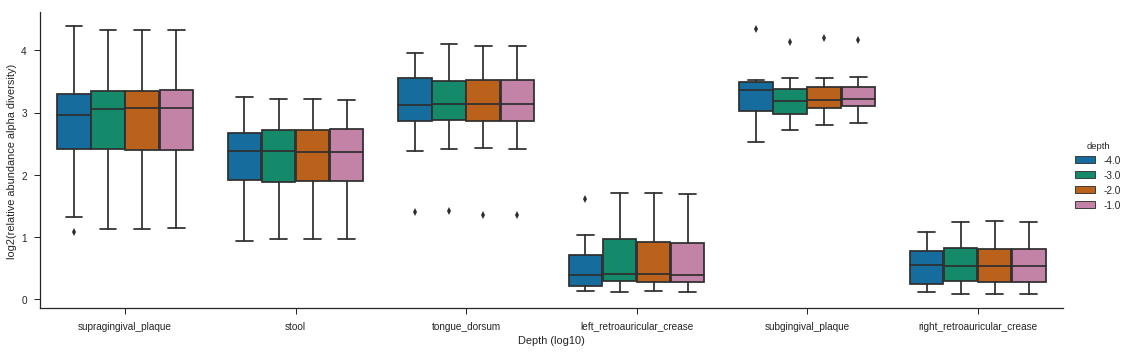

In [32]:
# df_result_cv_scores['mean'] = df_result_cv_scores.values[:,1:].mean(axis=1)
# df_result_cv_scores = df_result_cv_scores.sort_values('mean')
df_alpha.to_csv('../figures/hmp_alpha_table.txt')
fig = sns.factorplot(x="Body Site", y="alpha", hue="depth", data=df_alpha, palette=COLORS, kind="box", size=5, aspect=3)
fig.set_ylabels("log2(relative abundance alpha diversity)").set_xlabels("Depth (log10)")
pltname = "alpha_diversity"
save_plot(fig, pltname)

In [33]:
mapping_df['SRS ID']

0      SRS011061
1      SRS011090
2      SRS011098
3      SRS011126
4      SRS011132
5      SRS011134
6      SRS011140
7      SRS011144
8      SRS011152
9      SRS011239
10     SRS011243
11     SRS011247
12     SRS011255
13     SRS011263
14     SRS011269
15     SRS011271
16     SRS011302
17     SRS011306
18     SRS011310
19     SRS011343
20     SRS011355
21     SRS011397
22     SRS011405
23     SRS011452
24     SRS011529
25     SRS011584
26     SRS011586
27     SRS012273
28     SRS012279
29     SRS012281
         ...    
660    SRS063932
661    SRS063985
662    SRS063999
663    SRS064276
664    SRS064376
665    SRS064423
666    SRS064449
667    SRS064493
668    SRS064557
669    SRS064645
670    SRS064704
671    SRS064774
672    SRS064809
673    SRS065099
674    SRS065133
675    SRS065142
676    SRS065179
677    SRS065278
678    SRS065310
679    SRS065335
680    SRS065347
681    SRS065431
682    SRS065504
683    SRS075406
684    SRS075410
685    SRS077730
686    SRS077736
687    SRS0777

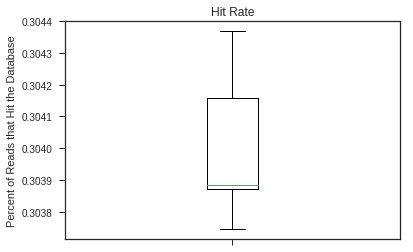

In [34]:
hit_rate
# multiple box plots on one figure
fig = plt.figure()
plt.boxplot(list(hit_rate.values()), labels=[""])
plt.ylabel("Percent of Reads that Hit the Database")
plt.title("Hit Rate")
save_plot(fig, "hit_rate")

In [35]:
def multiclass_roc(X, y, classifier=CLASSIFIER(), classes=['IGT', 'NGT', 'T2D']):
    # Binarize the output
    n_classes = len(classes)

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, stratify=y,
                                                        random_state=0)

    # Learn to predict each class against the other
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [36]:
def plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=2, classes=['IGT', 'NGT', 'T2D']):
    fig = plt.figure()
    lw = 2
    plt.plot(fpr[ix], tpr[ix], color=COLORS[0],
             lw=lw, label='%s ROC curve (area = %0.2f)' % (classes[ix], roc_auc[ix]), alpha=.8)
    plt.plot([0, 1], [0, 1], color=COLORS[1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if depth != 'fulldepth':
        plt.title('Receiver Operating Characteristic %s depth=.%s' % (classes[ix], str(depth)))
    else:
        plt.title('Receiver Operating Characteristic %s' % (classes[ix]))
    plt.legend(loc="lower right")
    save_plot(fig, 'roc_{}_{}'.format(depth, classes[ix]))
    
# Compute macro-average ROC curve and ROC area
def plot_multiroc_auc_classifier(depth, fpr, tpr, roc_auc, classes=['IGT', 'NGT', 'T2D']):
    lw=2
    n_classes = len(classes)
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4, alpha=.8)

    for i, color, target_name in zip(range(n_classes), COLORS, classes):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(target_name, roc_auc[i]), alpha=.8)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if depth != 'fulldepth':
        plt.title('Multiclass Receiver Operating Characteristic depth=.%s' % str(depth))
    else:
        plt.title('Multiclass Receiver Operating Characteristic')    
    plt.legend(loc="lower right")
    save_plot(fig, 'multiroc_{}'.format(depth))

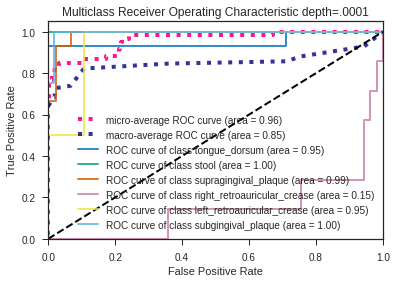

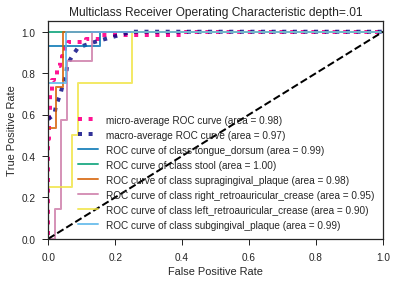

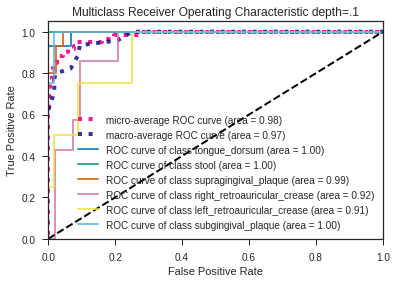

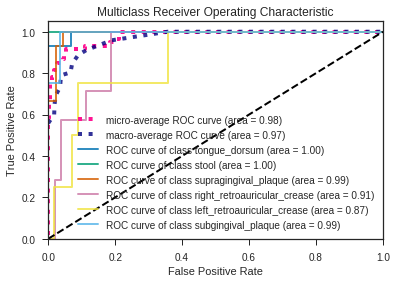

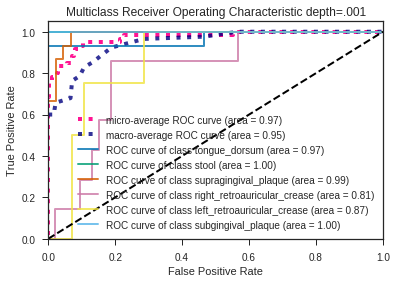

In [37]:
for depth, df in df_depths.items():
    temp_y = join_df["Body Site"].values
    temp_y = label_binarize(temp_y, classes=CLASSES)
#     mask = temp_y[:, 0] == 0
#     df = df[mask]
#     temp_y = temp_y[mask]
#     temp_y = temp_y[:, 1:]
    # Make full depth classifier with 1-CV
    fpr, tpr, roc_auc = multiclass_roc(df, temp_y, classes=CLASSES)
    plot_multiroc_auc_classifier(depth, fpr, tpr, roc_auc, classes=CLASSES)
#     for i in range(3):
#         plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=i)

In [38]:
result_cv_scores = []
for depth, df in df_depths.items():
    temp_y = join_df["Body Site"].values
    temp_y = label_binarize(temp_y, classes=CLASSES)
    mask = temp_y[:, 0] == 0
    df = df[mask]
    temp_y = temp_y[mask]
    temp_y = temp_y[:, 1:]
    # Make full depth classifier with 1-CV
#     fpr, tpr, roc_auc = multiclass_roc(df, temp_y, classes=CLASSES)
    # Glitches at past 5
    scores = cross_val_score(CLASSIFIER(), df, temp_y, cv=10, scoring="f1_micro")
    for score in scores:
        if depth == 'fulldepth':
            depth_name = 0
        else:
            depth_name = np.log10(float("." + str(depth)))
        result_cv_scores.append([depth_name, score, TAXONOMIC_PROFILER])
#     for i in range(len(CLASSES)):
#         plot_roc_auc_classifier(depth, fpr, tpr, roc_auc, ix=i, classes=CLASSES)
df_result_cv_scores = pd.DataFrame(result_cv_scores, columns=['depth', 'score', 'profiler'])

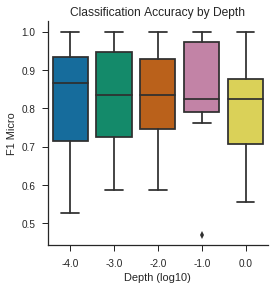

In [39]:
# df_result_cv_scores['mean'] = df_result_cv_scores.values[:,1:].mean(axis=1)
# df_result_cv_scores = df_result_cv_scores.sort_values('mean')
df_result_cv_scores.to_csv('../figures/hmp_f1_cv_table.txt')
g = sns.factorplot(x="depth", y="score", kind="box", data=df_result_cv_scores, palette=COLORS, legend=False)
g.set_ylabels("F1 Micro").set_xlabels("Depth (log10)")
plt.title("Classification Accuracy by Depth")
pltname = "f1"
save_plot(g, pltname)

In [40]:
def plot_pca(df_depths, y, colors=COLORS, classes=['NGT', 'T2D']):
    n_classes = len(classes)
    fulldepth_df = df_depths['fulldepth']
    pca = PCA(n_components=2)
    pca.fit(fulldepth_df)

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    
    for depth, df in df_depths.items():
        X_r = pca.transform(df)
        fig = plt.figure()
        lw = 2
        
        
        for color, target_name in zip(colors, classes):
            plt.scatter(X_r[y == target_name, 0], X_r[y == target_name, 1], color=color, alpha=.8, lw=lw,
                        label=target_name)
        lgd = plt.legend(shadow=False, scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5))
        if depth != 'fulldepth':
            plt.title('PCA of HMP dataset depth=.%s' % str(depth))
        else:
            plt.title('PCA of HMP dataset')
        save_plot(fig, 'pca_{}_nclasses{}'.format(depth, str(n_classes)), artists=(lgd,))

explained variance ratio (first two components): [ 0.64155525  0.11720137]


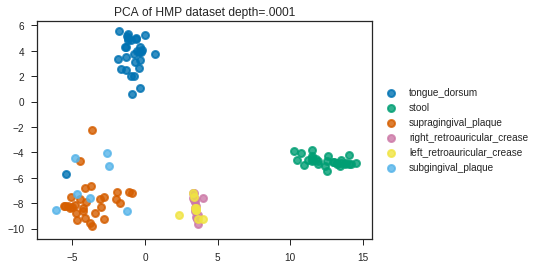

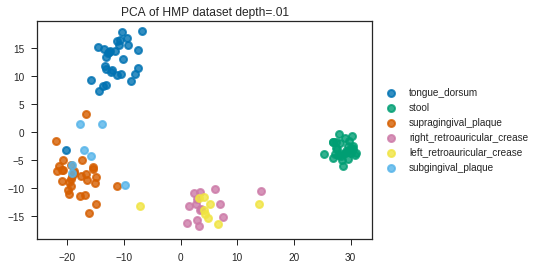

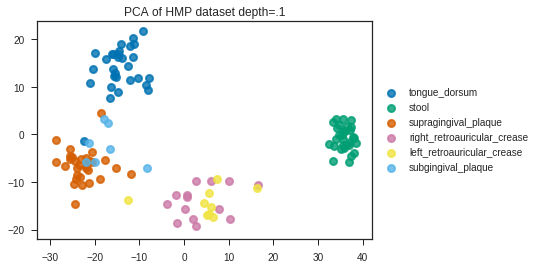

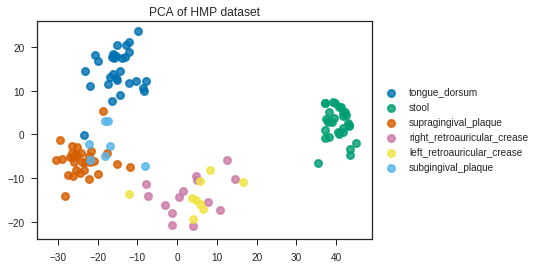

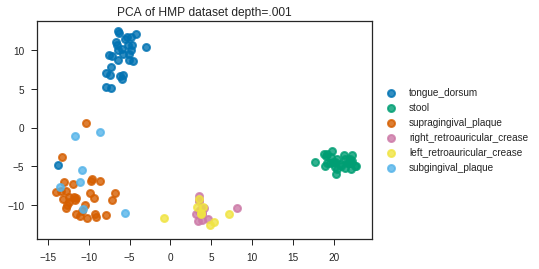

In [41]:
plot_pca(df_depths, join_df["Body Site"].values, classes=CLASSES)

In [42]:
def plot_lda(df_depths, y, colors=COLORS, classes=['NGT', 'T2D']):
    fulldepth_df = df_depths['fulldepth']
    n_classes = len(classes)
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(fulldepth_df, y).transform(fulldepth_df)
    
    lw = 2
    
    for depth, df in df_depths.items():
        X_r2 = lda.transform(df)
        fig = plt.figure()
        for color, target_name in zip(colors, classes):
            plt.scatter(X_r2[y == target_name, 0], X_r2[y == target_name, 1], alpha=.8, color=color, lw=lw, label=target_name)
        lgd = plt.legend(shadow=False, scatterpoints=1, loc='center left', bbox_to_anchor=(1, 0.5))
        if depth != 'fulldepth':
            plt.title('LDA of HMP dataset depth=.%s' % str(depth))
        else:
            plt.title('LDA of HMP dataset')
        save_plot(fig, 'lda_{}'.format(depth), artists=(lgd,))

/export/scratch/miniconda3/envs/analysis_SHOGUN/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


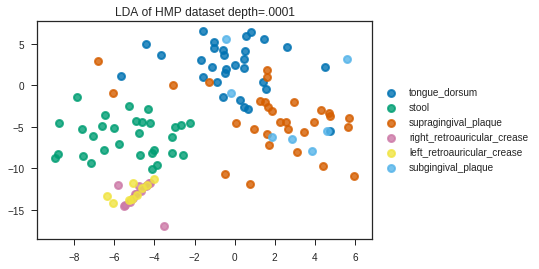

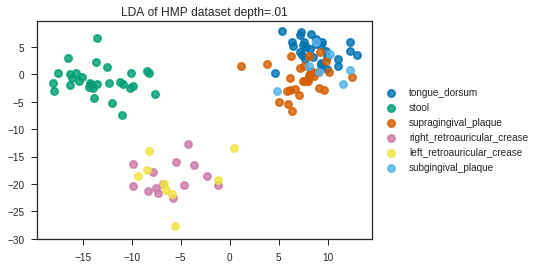

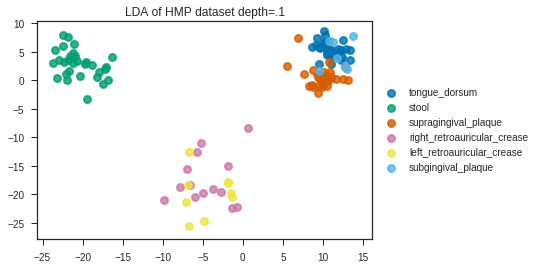

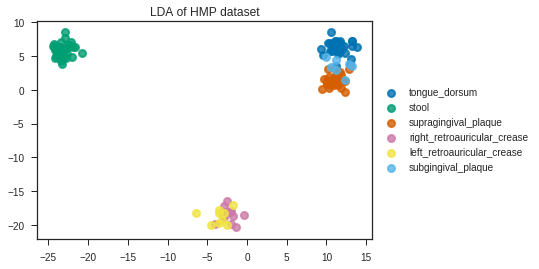

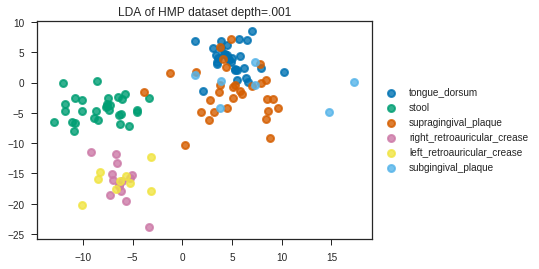

In [43]:
plot_lda(df_depths, join_df["Body Site"].values, classes=CLASSES)

In [44]:
# Spearman Correlation
from scipy.stats import pearsonr

def pearson_correlations(df_depths):
    pearson_correlations = []
    fulldepth_df = df_depths['fulldepth']
    for depth, df in df_depths.items():
        if depth != 'fulldepth':
            for i, row in fulldepth_df.iterrows():
                pearson_correlations.append([np.log10(float("." + str(depth))), pearsonr(row, df.loc[i])[0], 'burst'])
    pearson_correlations.append([0, 1.0, 'burst'])
    return pd.DataFrame(pearson_correlations, columns=['depth', 'correlation', 'profiler'])

In [45]:
pearson_df = pearson_correlations(df_depths)

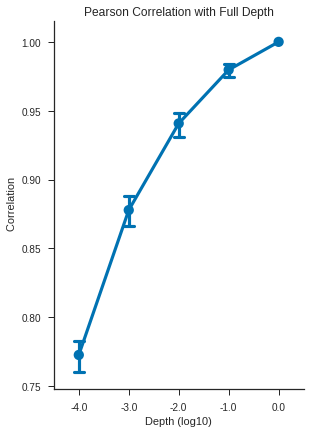

In [46]:
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=pearson_df, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels(" Correlation").set_xlabels("Depth (log10)")
plt.title("Pearson Correlation with Full Depth")
pltname = "pearson_correlation"
save_plot(g, pltname)

In [47]:
# Spearman Correlation
from scipy.stats import spearmanr

def spearman_correlations(df_depths):
    spearman_correlations = []
    fulldepth_df = df_depths['fulldepth']
    for depth, df in df_depths.items():
        if depth != 'fulldepth':
            for i, row in fulldepth_df.iterrows():
                spearman_correlations.append([np.log10(float("." + str(depth))), spearmanr(row, df.loc[i])[0], 'burst'])
    spearman_correlations.append([0, 1.0, 'burst'])
    return pd.DataFrame(spearman_correlations, columns=['depth', 'correlation', 'profiler'])

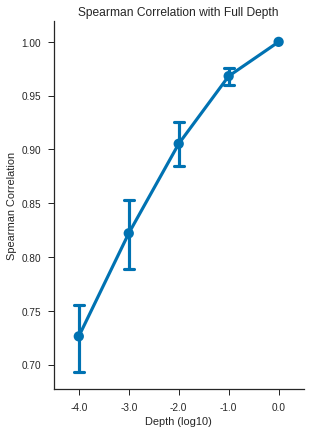

In [48]:
spearman_df = spearman_correlations(df_depths)
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=spearman_df, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels("Spearman Correlation").set_xlabels("Depth (log10)")
plt.title("Spearman Correlation with Full Depth")
pltname = "spearman_correlation"
save_plot(g, pltname)

In [49]:
# from skbio.stats.composition import ancom, clr_inv

# results = []
# for depth, df in df_depths.items():
#     if CLR:
#         data = clr_inv(df)
#         df = pd.DataFrame(data, index=df.index, columns=df.columns)
#     results.append([depth, ancom(df, join_df["Body Site"])])
    

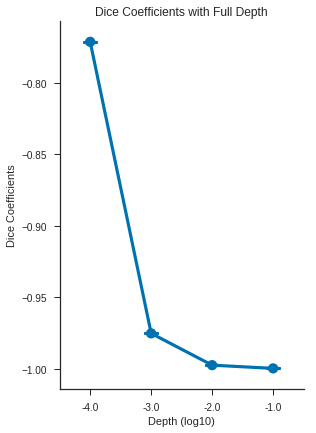

In [50]:
g = sns.factorplot(x="depth", y="correlation", hue="profiler", data=df_dice, palette=COLORS, capsize=.2, size=6, aspect=.75, alpha=.1, legend=False)
g.set_ylabels("Dice Coefficients").set_xlabels("Depth (log10)")
plt.title("Dice Coefficients with Full Depth")
pltname = "dice_coefficients"
save_plot(g, pltname)

In [51]:
print(CLASSES)

['tongue_dorsum', 'stool', 'supragingival_plaque', 'right_retroauricular_crease', 'left_retroauricular_crease', 'subgingival_plaque']


In [55]:
from skbio.stats.composition import ancom, clr_inv

results = []
for depth, df in df_depths.items():
    data = clr_inv(df)
    df = pd.DataFrame(data, index=df.index, columns=df.columns)
    df.to_csv("../results/hmp_{}_otu_table.txt".format(depth))